In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import r2_score

Loading and concatenating the word2vec tensor and VGG representation generated for our dataset which will serve as input features to the MLP

In [2]:
wv  = torch.load("./dataset/word2vec_emb_tensor.pkl")

In [3]:
cnn = torch.load("./dataset/vgg_cnn_emb_tensor.pkl")

In [4]:
X = torch.cat((wv,cnn),dim=1)

In [5]:
df = pd.read_csv("./dataset/books_with_genres.csv")

Setting the output labels for the prediction of rating

In [6]:
y = df["average_rating"]

In [7]:
y = y.to_numpy()
y = torch.from_numpy(y)

Train test split (80-20)

In [8]:
X_train = X[[i for i in range(4000)]]
X_test = X[[i for i in range(4000,5000)]]
y_train = y[[i for i in range(4000)]]
y_test = y[[i for i in range(4000, 5000)]]

Defining the MLP module and running it on GPU

In [9]:
device = torch.device("cuda")

In [10]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu1 = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [11]:
input_size = wv.shape[1]+cnn.shape[1]

In [12]:
net = MLP(input_size,1,512)

In [13]:
net=net.to(device)

Training the model

In [14]:


import torch.optim as optim
from random import randint

bs = 1

for epoch in range(50):

    criterion = nn.MSELoss()
    optimizer=torch.optim.SGD(net.parameters() , lr=5e-4 )

    for iter in range(1,1000):

        # create a minibatch
        indices=torch.LongTensor(bs).random_(0,4000)
        minibatch_data =  X_train[indices].to(device)
        minibatch_label = y_train[indices].float().to(device)

        #reshape them to fit the network
        inputs=minibatch_data.view(bs,1100)
        # feed the input to the net  
        inputs.requires_grad_()
        prob=net(inputs)

        loss = criterion(prob, minibatch_label)    
        optimizer.zero_grad()       
        loss.backward()
        optimizer.step()

C:\Users\AISWARYA\Miniconda3\envs\seat\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Testing the model

In [15]:
running_error=0
y_pred = []
y_true = []
num_batches=0

bs = 1

for i in range(0,1000,bs):

    # extract the minibatch
    minibatch_data =  X_test[i:i+bs].to(device)
    minibatch_label= y_test[i:i+bs].float().to(device)

    # reshape the minibatch
    inputs = minibatch_data.view(bs,input_size)

    with torch.set_grad_enabled(False):
    # feed it to the network
        scores=net( inputs ) 
        
        # compute the error made on this batch
        error = criterion( scores , minibatch_label)

        # add it to the running error
        running_error += error.item()
        num_batches += 1
        
        y_pred.append(scores.to('cpu'))
        y_true.append(minibatch_label.to('cpu'))

# compute error rate on the full test set
total_error = running_error/num_batches
total_r2 = r2_score(y_pred,y_true)

print( 'error rate on test set =', total_error)
print( 'r2 score on test set  =', total_r2)

error rate on test set = 0.2942995169455831
r2 score on test set  = -1.7345938849109173


C:\Users\AISWARYA\Miniconda3\envs\seat\lib\site-packages\sklearn\utils\validation.py:673: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = np.asarray(array, order=order, dtype=dtype)
C:\Users\AISWARYA\Miniconda3\envs\seat\lib\site-packages\sklearn\utils\validation.py:673: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype

In [16]:
pred = []
for i in range (0,1000):
    pred.append(net(X_test[i].to(device)).item())
pred = torch.tensor(pred)

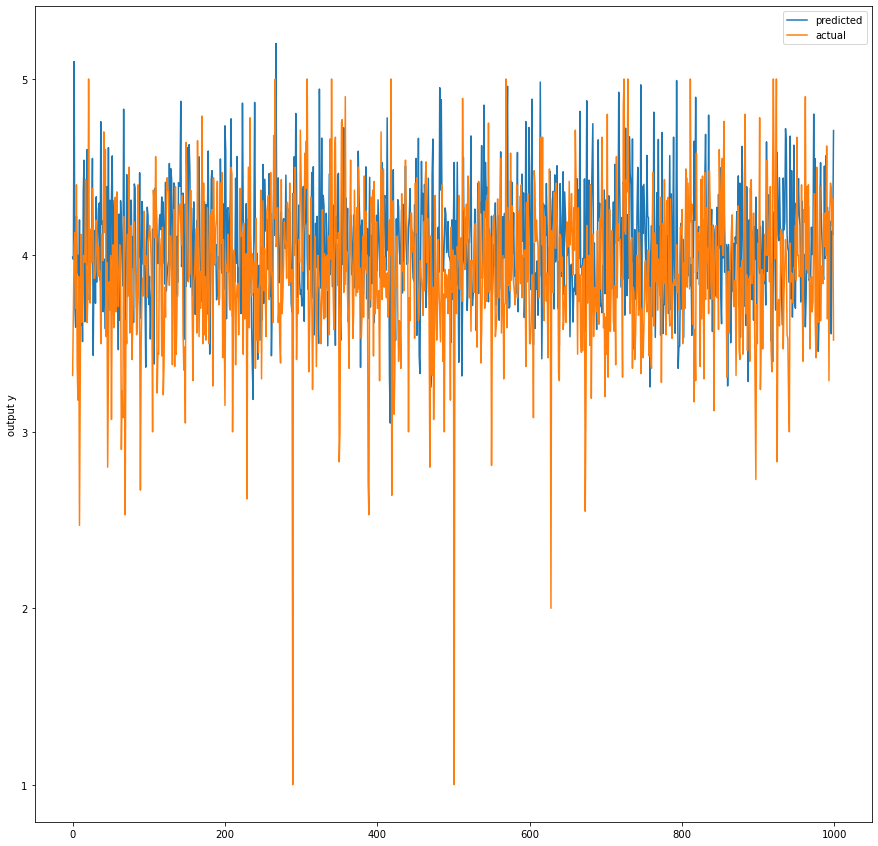

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
plt.plot(pred, label='predicted')
plt.plot(y_test, label='actual')
plt.ylabel('output y')
plt.legend()
plt.show()

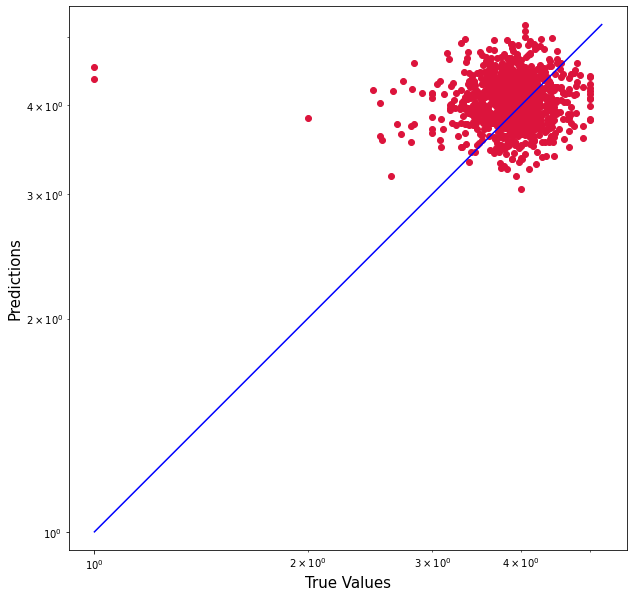

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(pred), max(y_test))
p2 = min(min(pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()